Send this ipynb file with your code (solution) to econometrics.methods@gmail.com

In the subject of the e-mail, copy and paste only the title of this file without the extension ".ipynb"

Write the name of the members of your group in the e-mail, and not here.

Only one student will send me the solution. This student is responsible to copy other members of the group in the e-mail. 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns
import graphviz

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

 We'll now be looking at a dataset of per-game stats for all NBA players in the 2018-19 season. This dataset comes from basketball-reference.com.

In [2]:
path ='https://github.com/VitorKamada/DataScience/raw/master/Labs/Data/'
nba_data = pd.read_csv(path +"nba18-19.csv")
nba_data.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,0.2,1.5,0.133,0.2,0.3,0.667,0.278,0.7,1.0,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,0.595,1.8,3.7,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,3.4,5.7,0.588,0.579,2.0,2.8,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


Our goal will be to predict a player's position given several other features. The 5 positions in basketball are PG, SG, SF, PF, and C (which stand for point guard, shooting guard, small forward, power forward, and center). This information is contained in the `Pos` column.

In [3]:
nba_data['Pos'].value_counts()

SG       176
PF       147
PG       139
C        120
SF       118
PF-SF      2
SF-SG      2
SG-SF      1
PF-C       1
C-PF       1
SG-PF      1
Name: Pos, dtype: int64

While we could set out to try and perform 5-class classification, the results (and visualizations) are slightly more interesting if we try and categorize players into 1 of 3 categories: **guard**, **forward**, and **center**. The below code will take the `Pos` column of our dataframe and use it to create `Pos3`.

In [4]:
def basic_position(pos):
    if 'F' in pos:
        return 'F'
    elif 'G' in pos:
        return 'G'
    return 'C'

nba_data['Pos3'] = nba_data['Pos'].apply(basic_position)
nba_data['Pos3'].value_counts()

G    315
F    273
C    120
Name: Pos3, dtype: int64

Furthermore, since there are **many** players in the NBA (in the 2018-19 season there were 530 unique players), our visualizations can tend to get noisy and messy. Let's restrict our data to only contain rows for players that averaged 10 or more points per game.

In [0]:
nba_data = nba_data[nba_data['PTS'] > 10]

Now, let's look at a scatterplot of Rebounds (`TRB`) vs. Assists (`AST`).

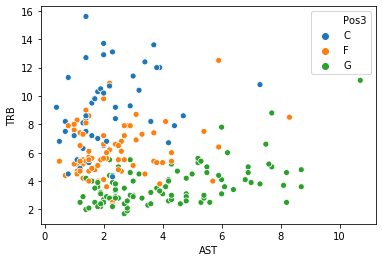

In [6]:
sns.scatterplot(data = nba_data, x = 'AST', y = 'TRB', hue = 'Pos3');

As you can see, when using just rebounds and assists as our features, we see pretty decent cluster separation. That is, Centers, Forwards, and Guards appear in different regions of the plot.

## One-vs-Rest Logistic Regression

We only discussed binary logistic regression in class, but there is a natural extension to binary logistic regression called one-vs-rest logistic regression for multiclass classification. This is discussed in the [extra slides in lecture 22](https://docs.google.com/presentation/d/18APMVrMwUYsL3F99P4vH1Ysxd-of-dPWhfN8gu7Hlg8/edit#slide=id.g70b8c9ba27_3_85). In essence, one-vs-rest logistic regression simply builds one binary logistic regression classifier for each of the $N$ classes (in this scenario $N = 3$). We then predict the class corresponding to the classifier that gives the highest probability among the $N$ classes.

Before using logistic regression, let's first split `nba_data` into a training set and test set.

In [0]:
nba_train, nba_test = train_test_split(nba_data, test_size=0.25, random_state=100)
nba_train = nba_train.sort_values(by='Pos')
nba_test = nba_test.sort_values(by='Pos')

### Question 2a

In the cell below, set `logistic_regression_model` to be a one-vs-rest logistic regression model. Then, fit that model using the `AST` and `TRB` columns (in that order) from `nba_train` as our features, and `Pos3` as our response variable.

Remember, [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has already been imported for you. There is an optional parameter you need to specify in order to make your model a multi-class one-vs-rest classifier. See the documentation for more details.

<!--
BEGIN QUESTION
name: q2a
-->

In [0]:
logistic_regression_model = ...
...

To see our classifier in action, we can use `logistic_regression_model.predict` and see what it outputs.

In [9]:
nba_train['Predicted (OVRLR) Pos3'] = logistic_regression_model.predict(nba_train[['AST', 'TRB']])
nba_train[['AST', 'TRB', 'Pos3', 'Predicted (OVRLR) Pos3']].head(15)

AttributeError: ignored

Our model does decently well here, as you can see visually above. Below, we compute the training accuracy:

In [0]:
lr_training_accuracy = logistic_regression_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
lr_training_accuracy

We can compute the test accuracy as well by looking at `nba_test` instead of `nba_train`:

In [0]:
lr_test_accuracy = logistic_regression_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
lr_test_accuracy

Now, let's draw the decision boundary for this logistic regression classifier, and see how the classifier performs on both the training and test data.

In [0]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_train');

In [0]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_test');

Our one-vs-rest logistic regression was able to find a linear decision boundary between the three classes. It generally classifies centers as players with a lot of rebounds, forwards as players with a medium number of rebounds and a low number of assists, and guards as players with a low number of rebounds. 

Note: In practice we would use many more features – we only used 2 here just so that we could visualize the decision boundary.

## Decision Trees

### Question 2b

Let's now create a decision tree classifier on the same training data `nba_train`, and look at the resulting decision boundary. 

In the following cell, first, use [`tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to fit a model using the same features and response as above, and call this model `decision_tree_model`. Set the `random_state` parameter to 42.

**Hint:** Your code will be mostly be the same as question 2a.

<!--
BEGIN QUESTION
name: q2b
-->

In [0]:
decision_tree_model = ...
...

Now, let's draw the decision boundary for this decision tree classifier, and see how the classifier performs on both the training and test data.

In [0]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_train');

In [0]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_test');

### Question 2c

Set `dt_training_accuracy` to be the training accuracy of the decision tree model and `dt_test_accuracy` to be the test accuracy.

**Hint:** If you're failing this test, make sure you have the correct `random_state` parameter to `tree.DecisionTreeClassifier` in question 2b.

<!--
BEGIN QUESTION
name: q2c
-->

In [0]:
dt_training_accuracy = ...
dt_test_accuracy = ...
dt_training_accuracy, dt_test_accuracy

## Random Forests

### Question 2d

Let's now create a random forest classifier on the same training data `nba_train` and look at the resulting decision boundary. 

In the following cell, use [`ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to fit a model using the same features and response as above, and call this model `random_forest_model`. Use 20 trees in your random forest classifier, and set the `random_state` parameter to 42.

**Hint:** Your code for both parts will be mostly the same as questions 2a and 2b.

**Hint:** Look at the `n_estimators` parameter of `ensemble.RandomForestClassifier`.

<!--
BEGIN QUESTION
name: q2d
-->

In [0]:
random_forest_model = ...
...

Now, let's draw the decision boundary for this random forest classifier, and see how the classifier performs on both the training and test data.

In [0]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_train');

In [0]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_test');

### Question 2e

Set `rf_train_accuracy` to be the training accuracy of the random forest model and `rf_test_accuracy` to be the test accuracy.

**Hint:** If you're failing this test, make sure you have the correct parameters to `ensemble.RandomForestClassifier` in question 2d.

<!--
BEGIN QUESTION
name: q2e
-->

In [0]:
rf_train_accuracy = ...
rf_test_accuracy = ...
rf_train_accuracy, rf_test_accuracy

### Question 2f

Looking at the three models you created (multiclass one-vs-rest logistic regression, decision tree, random forest), which model performed the best on the training set, and which model performed the best on the test set? How are the training and test accuracy related for the three models, and how do the decision boundaries generated for each of the three models relate to the model's performance?

<!--
BEGIN QUESTION
name: q2f
-->

*Write your answer here, replacing this text.*